In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# other
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

cuda


/home/junseung/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
batch_size=200
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 1채널 -> 3채널
    #transforms.Resize((224, 224)),  # (28, 28) -> (224, 224)
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

In [3]:
train_dataset = datasets.MNIST(root='./dataset/02/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./dataset/02/', train=False, download=True, transform=transform)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


trainset = datasets.CIFAR10(root='dataset/',train=True,
                                        download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset = datasets.CIFAR10(root='dataset/',train=False,
                                       download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

torch.cuda.empty_cache()

resnet18_pt = models.resnet18(pretrained=True).to(device)
resnet34_pt = models.resnet34(pretrained=True).to(device)
googlenet_pt = models.googlenet(pretrained=True).to(device)
densenet121_pt = models.densenet121(pretrained=True).to(device)


In [4]:
# Models setting
def modify_model(model, num_classes=10):
    if isinstance(model, models.ResNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.GoogLeNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        if model.aux1 is not None:  # Auxiliary classifiers가 활성화된 경우에만 수정
            model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
        if model.aux2 is not None:
            model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)
    elif isinstance(model, models.DenseNet):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

In [5]:
# Pretrained models
torch.cuda.empty_cache()
resnet_pt = modify_model(models.resnet18(pretrained=True)).to(device)
googlenet_pt = modify_model(models.googlenet(pretrained=True, aux_logits=True)).to(device)
densenet_pt = modify_model(models.densenet121(pretrained=True)).to(device)

/home/junseung/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/junseung/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/junseung/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAU

In [6]:
# Loss function and optimizers setting
criterion = nn.CrossEntropyLoss()
error_fn = nn.MSELoss()
resnet_optimizer = optim.Adam(resnet_pt.parameters(), lr=0.001)
googlenet_optimizer = optim.Adam(googlenet_pt.parameters(), lr=0.001)
densenet_optimizer = optim.Adam(densenet_pt.parameters(), lr=0.001)

In [7]:
# Training
def train(epoch, model, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        if isinstance(outputs, tuple):  # GoogLeNet
                outputs = outputs[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = train_loss/total
    epoch_acc = correct/total*100
    print("Train | Loss:%.4f" 
        % epoch_loss)
    return epoch_loss, epoch_acc

# Training
def ft_train(epoch, model1, model2, criterion, error_fn, optimizer1, optimizer2):
    model1.train()
    model2.train()
    train_loss = 0
    correct1 = 0
    correct2 = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        outputs1 = model1(inputs)
        if isinstance(outputs1, tuple):  # GoogLeNet
                outputs1 = outputs1[0]
        outputs2 = model2(inputs)
        if isinstance(outputs2, tuple):  # GoogLeNet
                outputs2 = outputs2[0]
        loss = (0.5 * criterion(outputs1, labels) + 0.5 * criterion(outputs2, labels)) + error_fn(outputs1, outputs2) # setting
        loss.backward()
        optimizer1.step()
        optimizer2.step()

        train_loss += loss.item()*inputs.size(0)
        _, predicted1 = outputs1.max(1)
        _, predicted2 = outputs2.max(1)
        total += labels.size(0)
        correct1 += predicted1.eq(labels).sum().item()
        correct2 += predicted2.eq(labels).sum().item()
    
    epoch_loss = train_loss/total
    epoch_acc1 = correct1/total*100
    epoch_acc2 = correct2/total*100
    print("F-Train | Loss:%.4f " 
        % epoch_loss)
    return epoch_loss, epoch_acc1, epoch_acc2

def test(epoch, model, criterion, optimizer):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):  # GoogLeNet
                outputs = outputs[0]
            loss = criterion(outputs, labels)

            test_loss += loss.item()*inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = test_loss/total
        epoch_acc = correct/total*100
        print("Test | Loss:%.4f" 
            % epoch_loss)
    return epoch_loss, epoch_acc

In [8]:
# train ResNet18
start_time = time.time()
#best_acc = 0
epoch_length = 50
save_loss_rn = {"train":[],
             "test":[]}
save_acc_rn = {"train":[],
             "test":[]}
for epoch in range(epoch_length):
    print("Epoch %s" % epoch)
    train_loss, train_acc = train(epoch, resnet_pt, criterion, resnet_optimizer)
    save_loss_rn['train'].append(train_loss)
    save_acc_rn['train'].append(train_acc)

    test_loss, test_acc = test(epoch, resnet_pt, criterion, resnet_optimizer)
    save_loss_rn['test'].append(test_loss)
    save_acc_rn['test'].append(test_acc)

    # Save model
    #if test_acc > best_acc:
    #    best_acc = test_acc
    #    best_model_wts = copy.deepcopy(resnet_pt.state_dict())
    #resnet_pt.load_state_dict(best_model_wts)

learning_time = time.time() - start_time
print(f'**Learning time: {learning_time // 60:.0f}m {learning_time % 60:.0f}s')

Epoch 0
Train | Loss:0.1062
Test | Loss:0.0470
Epoch 1
Train | Loss:0.0421
Test | Loss:0.0280
Epoch 2
Train | Loss:0.0311
Test | Loss:0.0807
Epoch 3
Train | Loss:0.0311
Test | Loss:0.0282
Epoch 4
Train | Loss:0.0252
Test | Loss:0.0289
Epoch 5
Train | Loss:0.0210
Test | Loss:0.0250
Epoch 6
Train | Loss:0.0181
Test | Loss:0.0377
Epoch 7
Train | Loss:0.0154
Test | Loss:0.0361
Epoch 8
Train | Loss:0.0193
Test | Loss:0.0303
Epoch 9
Train | Loss:0.0141
Test | Loss:0.0297
Epoch 10
Train | Loss:0.0157
Test | Loss:0.0222
Epoch 11
Train | Loss:0.0124
Test | Loss:0.0402
Epoch 12
Train | Loss:0.0100
Test | Loss:0.0312
Epoch 13
Train | Loss:0.0131
Test | Loss:0.0262
Epoch 14
Train | Loss:0.0111
Test | Loss:0.0280
Epoch 15
Train | Loss:0.0099
Test | Loss:0.0332
Epoch 16
Train | Loss:0.0084
Test | Loss:0.0326
Epoch 17
Train | Loss:0.0081
Test | Loss:0.0382
Epoch 18
Train | Loss:0.0095
Test | Loss:0.0332
Epoch 19
Train | Loss:0.0075
Test | Loss:0.0231
Epoch 20
Train | Loss:0.0077
Test | Loss:0.0214
Ep

In [9]:
# train Googlenet
start_time = time.time()
#best_acc = 0
epoch_length = 50
save_loss_gn = {"train":[],
             "test":[]}
save_acc_gn = {"train":[],
             "test":[]}
for epoch in range(epoch_length):
    print("Epoch %s" % epoch)
    train_loss, train_acc = train(epoch, googlenet_pt, criterion, googlenet_optimizer)
    save_loss_gn['train'].append(train_loss)
    save_acc_gn['train'].append(train_acc)

    test_loss, test_acc = test(epoch, googlenet_pt, criterion, googlenet_optimizer)
    save_loss_gn['test'].append(test_loss)
    save_acc_gn['test'].append(test_acc)

    # Save model
    #if test_acc > best_acc:
    #    best_acc = test_acc
    #    best_model_wts = copy.deepcopy(resnet_pt.state_dict())
    #alexnet_pt.load_state_dict(best_model_wts)

learning_time = time.time() - start_time
print(f'**Learning time: {learning_time // 60:.0f}m {learning_time % 60:.0f}s')

Epoch 0
Train | Loss:0.1680
Test | Loss:0.0434
Epoch 1
Train | Loss:0.0445
Test | Loss:0.0355
Epoch 2
Train | Loss:0.0340
Test | Loss:0.0327
Epoch 3
Train | Loss:0.0271
Test | Loss:0.0487
Epoch 4
Train | Loss:0.0223
Test | Loss:0.0316
Epoch 5
Train | Loss:0.0228
Test | Loss:0.0403
Epoch 6
Train | Loss:0.0204
Test | Loss:0.0255
Epoch 7
Train | Loss:0.0167
Test | Loss:0.0327
Epoch 8
Train | Loss:0.0159
Test | Loss:0.0270
Epoch 9
Train | Loss:0.0161
Test | Loss:0.0342
Epoch 10
Train | Loss:0.0169
Test | Loss:0.0282
Epoch 11
Train | Loss:0.0127
Test | Loss:0.0418
Epoch 12
Train | Loss:0.0099
Test | Loss:0.0301
Epoch 13
Train | Loss:0.0096
Test | Loss:0.0379
Epoch 14
Train | Loss:0.0118
Test | Loss:0.0350
Epoch 15
Train | Loss:0.0111
Test | Loss:0.0270
Epoch 16
Train | Loss:0.0099
Test | Loss:0.0253
Epoch 17
Train | Loss:0.0082
Test | Loss:0.0352
Epoch 18
Train | Loss:0.0094
Test | Loss:0.0312
Epoch 19
Train | Loss:0.0097
Test | Loss:0.0313
Epoch 20
Train | Loss:0.0075
Test | Loss:0.0239
Ep

In [10]:
torch.cuda.empty_cache()

resnet_pt = modify_model(models.resnet18(pretrained=True)).to(device)
googlenet_pt = modify_model(models.googlenet(pretrained=True)).to(device)
densenet_pt = modify_model(models.densenet121(pretrained=True)).to(device)


In [11]:
criterion = nn.CrossEntropyLoss()
error_fn = nn.MSELoss()
resnet_optimizer = optim.Adam(resnet_pt.parameters(), lr=0.001)
googlenet_optimizer = optim.Adam(googlenet_pt.parameters(), lr=0.001)
densenet_optimizer = optim.Adam(densenet_pt.parameters(), lr=0.001)

In [12]:
# train Resnet-Googlenet
start_time = time.time()
#best_acc = 0
epoch_length = 50
save_loss_rg_r = {"train":[],
             "test":[]}
save_loss_rg_g = {"train":[],
             "test":[]}
save_acc_rg_r = {"train":[],
             "test":[]}
save_acc_rg_g = {"train":[],
             "test":[]}
for epoch in range(epoch_length):
    print("Epoch %s" % epoch)
    train_loss, train_acc1, train_acc2 = ft_train(epoch, resnet_pt, googlenet_pt, criterion, error_fn, resnet_optimizer, googlenet_optimizer)
    save_loss_rg_r['train'].append(train_loss)
    save_loss_rg_g['train'].append(train_loss)
    save_acc_rg_r['train'].append(train_acc1)
    save_acc_rg_g['train'].append(train_acc2)

    test_loss, test_acc = test(epoch, resnet_pt, criterion, resnet_optimizer)
    save_loss_rg_r['test'].append(test_loss)
    save_acc_rg_r['test'].append(test_acc)
    test_loss, test_acc = test(epoch, googlenet_pt, criterion, googlenet_optimizer)
    save_loss_rg_g['test'].append(test_loss)
    save_acc_rg_g['test'].append(test_acc)

    # Save model
    #if test_acc > best_acc:
    #    best_acc = test_acc
    #    best_model_wts = copy.deepcopy(resnet_pt.state_dict())
    #resnet_pt.load_state_dict(best_model_wts)

learning_time = time.time() - start_time
print(f'**Learning time: {learning_time // 60:.0f}m {learning_time % 60:.0f}s')

Epoch 0
F-Train | Loss:0.3327 
Test | Loss:0.0566
Test | Loss:0.0655
Epoch 1
F-Train | Loss:0.1373 
Test | Loss:0.0537
Test | Loss:0.0478
Epoch 2
F-Train | Loss:0.1170 
Test | Loss:0.0479
Test | Loss:0.0592
Epoch 3
F-Train | Loss:0.1060 
Test | Loss:0.0561
Test | Loss:0.0465
Epoch 4
F-Train | Loss:0.0976 
Test | Loss:0.0353
Test | Loss:0.0395
Epoch 5
F-Train | Loss:0.0940 
Test | Loss:0.0416
Test | Loss:0.0396
Epoch 6
F-Train | Loss:0.0836 
Test | Loss:0.0376
Test | Loss:0.0334
Epoch 7
F-Train | Loss:0.0850 
Test | Loss:0.0398
Test | Loss:0.0412
Epoch 8
F-Train | Loss:0.0793 
Test | Loss:0.0358
Test | Loss:0.0353
Epoch 9
F-Train | Loss:0.0755 
Test | Loss:0.0365
Test | Loss:0.0385
Epoch 10
F-Train | Loss:0.0751 
Test | Loss:0.0325
Test | Loss:0.0419
Epoch 11
F-Train | Loss:0.0722 
Test | Loss:0.0353
Test | Loss:0.0329
Epoch 12
F-Train | Loss:0.0681 
Test | Loss:0.0334
Test | Loss:0.0303
Epoch 13
F-Train | Loss:0.0706 
Test | Loss:0.0344
Test | Loss:0.0313
Epoch 14
F-Train | Loss:0.0653

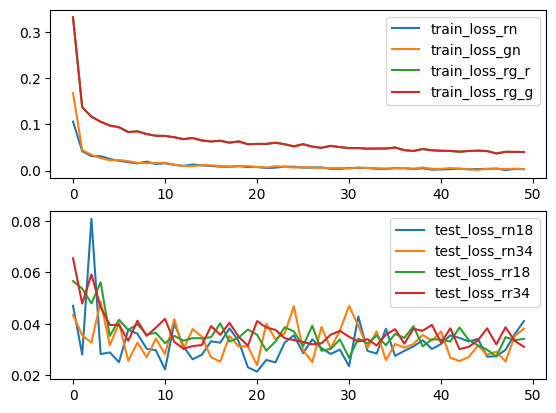

In [13]:
plt.subplot(2, 1, 1)
plt.plot(range(epoch_length), save_loss_rn["train"])
plt.plot(range(epoch_length), save_loss_gn["train"])
plt.plot(range(epoch_length), save_loss_rg_r["train"])
plt.plot(range(epoch_length), save_loss_rg_g["train"])
plt.legend(('train_loss_rn', 'train_loss_gn', 'train_loss_rg_r', 'train_loss_rg_g'))
plt.subplot(2, 1, 2)
plt.plot(range(epoch_length), save_loss_rn["test"])
plt.plot(range(epoch_length), save_loss_gn["test"])
plt.plot(range(epoch_length), save_loss_rg_r["test"])
plt.plot(range(epoch_length), save_loss_rg_g["test"])
plt.legend(('test_loss_rn18', 'test_loss_rn34', 'test_loss_rr18', 'test_loss_rr34'))
plt.show()

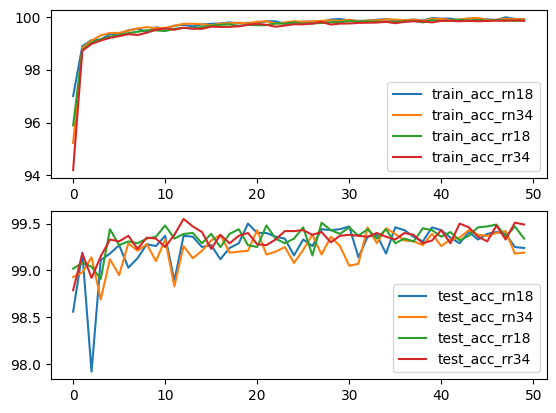

In [14]:
plt.subplot(2, 1, 1)
plt.plot(range(epoch_length), save_acc_rn["train"])
plt.plot(range(epoch_length), save_acc_gn["train"])
plt.plot(range(epoch_length), save_acc_rg_r["train"])
plt.plot(range(epoch_length), save_acc_rg_g["train"])
plt.legend(('train_acc_rn18', 'train_acc_rn34', 'train_acc_rr18', 'train_acc_rr34'))
plt.subplot(2, 1, 2)
plt.plot(range(epoch_length), save_acc_rn["test"])
plt.plot(range(epoch_length), save_acc_gn["test"])
plt.plot(range(epoch_length), save_acc_rg_r["test"])
plt.plot(range(epoch_length), save_acc_rg_g["test"])
plt.legend(('test_acc_rn18', 'test_acc_rn34', 'test_acc_rr18', 'test_acc_rr34'))
plt.show()